# Just operation policies of Guadalajara’s Aquapheric under drought conditions

## Formulation 1 plan. No uncertainties except flows
1. Define ranges of the flow under drought based on the average 2020 flow. Currently set to 0 and 150% of the average flow for all sources. L
2. Define the supplied demand ratio of each supply area + a justice as objectives (min for now)
3. Aquapheric flows as levers currently. Later Original RBFs (inputs: water flows5, outputs: AqP flows4) (not implemented)
5. Conduct an optimization (n policies, x scenarios (water flows)) This will produce a dataframe with n policies that generate n sets of objectives for each scenario.
7. Calculate an indicator of performance for each policy and each objective across all the scenarios. (average for now)
8. Visualize

### Unresolved issues
* How to visualize other outcomes when using Optimize Evaluator


In [1]:


from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, Scenario, Constraint,optimize)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\ema_workbench\em_framework\evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [2]:
from AMG_function import AMG_model_function
import numpy as np

outcomes = AMG_model_function(chapala_flow= 4.9, calderon_flow= 0.6, zapotillo_flow= 0.4, pozos_flow= 1.6, toluquilla_flow= 0.6, 
                aqp1_PP2_to_PP3=-0.2, aqp2_PP3_to_Pozos=-0.2, aqp3_Pozos_to_Toluquilla=-0.3, aqp4_Toluquilla_to_PP1=-0.2)



print(outcomes)




{'supplied_PP1': 1.9813492400000003, 'supplied_PP2': 0.6927895000000001, 'supplied_PP3': 0.8125, 'supplied_Toluquilla': 0.60641126, 'supplied_Pozos': 0.8762000000000001, 'demand_PP1': 2.32436, 'demand_PP2': 0.6546, 'demand_PP3': 0.76724, 'demand_Toluquilla': 0.67242, 'demand_Pozos': 1.04161, 'delivered_PP1': 3.9690000000000007, 'delivered_PP2': 0.931, 'delivered_PP3': 1.0, 'delivered_Toluquilla': 0.6, 'delivered_Pozos': 1.6, 'supplied_demand_PP1': 0.85243, 'supplied_demand_PP2': 1.05834, 'supplied_demand_PP3': 1.05899, 'supplied_demand_Toluquilla': 0.90183, 'supplied_demand_Pozos': 0.8412, 'supplied_demand_deficit_PP1': 0.14756999999999998, 'supplied_demand_deficit_PP2': 0.05834000000000006, 'supplied_demand_deficit_PP3': 0.0589900000000001, 'supplied_demand_deficit_Toluquilla': 0.09816999999999998, 'supplied_demand_deficit_Pozos': 0.15880000000000005, 'supply_percapita_PP1': 0.0, 'supply_percapita_PP2': 0.0, 'supply_percapita_PP3': 0.0, 'supply_percapita_Toluquilla': 0.0, 'supply_perc

# 1. Tests for a single drought scenario and no uncertainty

In [3]:

drougth_multiplier_1 = 0.7
scenario1= Scenario("drought1", 
                    chapala_flow = 6.9*drougth_multiplier_1, 
                    calderon_flow = 1*drougth_multiplier_1, 
                    zapotillo_flow = 1*drougth_multiplier_1, 
                    pozos_flow = 2.3*drougth_multiplier_1, 
                    toluquilla_flow = 0.5*drougth_multiplier_1)

## 1.1 Formulation 1 with only disagregated supplied demand outcomes

In [4]:
ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]
maximizing_outcomes = [f"supplied_demand_{ZA}" for ZA in ZA_names]
maximizing_outcomes

['supplied_demand_PP1',
 'supplied_demand_PP2',
 'supplied_demand_PP3',
 'supplied_demand_Toluquilla',
 'supplied_demand_Pozos']

In [5]:
[1,2] + [3]

[1, 2, 3]

In [6]:
from AMG_function import AMG_model_function

ema_logging.log_to_stderr(ema_logging.INFO)

ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model_function)

#Levers

AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

#Outcomes

maximizing_outcomes = [f"supplied_demand_{ZA}" for ZA in ZA_names] #separate lists of maximizing and minizmizing objectives for simplicity
info_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
minimizing_outcomes = []

AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
    ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
    ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes]


In [7]:
ZA_names

['PP1', 'PP2', 'PP3', 'Toluquilla', 'Pozos']

In [8]:
#Using supplied demand and a non negatyive constrain
ema_logging.log_to_stderr(ema_logging.INFO)
drougth_multiplier = 0.7
scenario1= Scenario("drought1", chapala_flow = 6.9*drougth_multiplier, 
                    calderon_flow = 1*drougth_multiplier, zapotillo_flow = 1*drougth_multiplier, 
                    pozos_flow = 2.3*drougth_multiplier, toluquilla_flow = 0.5*drougth_multiplier)

non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
constraints = [Constraint("non_negative_constrain", outcome_names= outcome, 
                         function=lambda x: max(0, -x)) for outcome in non_negative_outcomes]

with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=1000, searchover="levers", epsilons=[0.05] * 5, constraints = constraints, reference=scenario1
    )

results.head(10)

[MainProcess/INFO] pool started with 8 workers
  0%|                                                 | 0/1000 [00:00<?, ?it/s]

1087it [00:07, 153.35it/s]                                                     
[MainProcess/INFO] optimization completed, found 388 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_PP1,supplied_demand_PP2,supplied_demand_PP3,supplied_demand_Toluquilla,supplied_demand_Pozos
0,-0.648633,-0.502426,0.260016,0.889023,1.14399,1.49154,1.25198,0.15979,0.30787
1,0.287153,0.052045,-0.390360,-0.873244,0.65118,0.56233,1.57502,1.23461,1.05974
2,0.821907,0.532409,-0.194759,0.454322,1.02243,0.03133,1.62110,0.14039,1.23744
3,-0.366096,0.991241,0.533394,-0.992336,0.61788,1.21099,0.22592,2.24269,1.06937
4,0.822866,0.777135,-0.392160,0.119963,0.92893,0.03038,1.41458,0.27278,1.51334
5,-0.133943,0.439011,-0.469055,-0.088082,0.87075,0.98047,0.89044,0.39956,1.35033
6,-0.533650,0.365964,0.654479,-0.612477,0.72410,1.37736,0.61369,1.99254,0.60362
7,0.589750,0.672865,-0.417765,-0.196543,0.84042,0.26186,1.30543,0.55398,1.46425
8,-0.583009,-0.041821,0.293242,0.997726,1.17439,1.42638,0.91735,0.08683,0.57457
9,-0.736928,-0.711286,0.353934,0.749633,1.10501,1.57921,1.35412,0.38532,0.11893


## 1.2 Formulation with supplied demand deficit

In [9]:
from AMG_function import AMG_model_function

ema_logging.log_to_stderr(ema_logging.INFO)

ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model_function)

#Levers
AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

#Outcomes
maximizing_outcomes = [] 
info_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
minimizing_outcomes = [f"supplied_demand_deficit_{ZA}" for ZA in ZA_names] #separate lists of maximizing and minizmizing objectives for simplicity

AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
    ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
    ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes]



In [10]:
#Using supplied demand an a non negatyive constrain
ema_logging.log_to_stderr(ema_logging.INFO)
drougth_multiplier = 0.7
scenario1= Scenario("drought1", chapala_flow = 6.9*drougth_multiplier, calderon_flow = 1*drougth_multiplier, zapotillo_flow = 1*drougth_multiplier, pozos_flow = 2.3*drougth_multiplier, toluquilla_flow = 0.5*drougth_multiplier)


with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=2500, searchover="levers", epsilons=[0.05] * 5, reference=scenario1
    )

results.head(10)

[MainProcess/INFO] pool started with 8 workers
2550it [00:07, 327.79it/s]                                                     
[MainProcess/INFO] optimization completed, found 54 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_deficit_PP1,supplied_demand_deficit_PP2,supplied_demand_deficit_PP3,supplied_demand_deficit_Toluquilla,supplied_demand_deficit_Pozos
0,-0.121079,0.198320,0.184652,0.199156,0.04893,0.03231,0.10525,0.24619,0.20781
1,-0.097995,0.433069,0.163057,0.280959,0.02605,0.05523,0.07407,0.34614,0.04784
2,-0.265023,0.195490,0.156156,0.174790,0.05574,0.11062,0.01430,0.25018,0.19179
3,-0.197761,0.137249,0.155344,0.203934,0.04759,0.04383,0.09202,0.27914,0.22763
4,-0.097995,0.433069,0.253585,0.280959,0.02605,0.05523,0.07407,0.25863,0.10433
5,-0.025310,0.526460,0.168097,0.233271,0.03939,0.12740,0.09161,0.29517,0.00729
6,0.010903,0.433069,0.081111,0.429679,0.01554,0.16336,0.01818,0.56912,0.00330
7,-0.079937,0.368343,0.724760,0.489211,0.03219,0.07316,0.00394,0.00448,0.43875
8,-0.284484,0.177426,0.179517,0.106968,0.07471,0.12995,0.01549,0.16204,0.21764
9,-0.204347,0.197857,0.040655,0.203934,0.04759,0.05037,0.03510,0.39001,0.11824


In [11]:
#Using supplied demand an a non negative constrain
ema_logging.log_to_stderr(ema_logging.INFO)
drougth_multiplier = 0.5
scenario1= Scenario("drought1", chapala_flow = 6.9*drougth_multiplier, calderon_flow = 1*drougth_multiplier, zapotillo_flow = 1*drougth_multiplier, pozos_flow = 2.3*drougth_multiplier, toluquilla_flow = 0.5*drougth_multiplier)

outcome_names = [f"supplied_demand_deficit_{ZA}" for ZA in ZA_names]


non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
less_than_x_outcomes = [f"supplied_demand_deficit_{ZA}" for ZA in ZA_names]
x= 3

constraints = [Constraint("non_negative_constrain", outcome_names= outcome, 
                         function=lambda x: max(0, -x)) for outcome in non_negative_outcomes] 
                             
'''+ [Constraint("less_than_x", outcome_names= outcome,function=lambda x: max(0, min(x, x))) for outcome in less_than_x_outcomes]'''
                         

with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=10000, searchover="levers", epsilons=[0.05] * 5, constraints = constraints, reference=scenario1
    )


results.head(10)

[MainProcess/INFO] pool started with 8 workers
13885it [01:43, 133.56it/s]                                                    
[MainProcess/INFO] optimization completed, found 1609 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_deficit_PP1,supplied_demand_deficit_PP2,supplied_demand_deficit_PP3,supplied_demand_deficit_Toluquilla,supplied_demand_deficit_Pozos
0,-0.312743,-0.049640,0.557928,0.276890,0.28301,0.08412,0.24016,0.17988,0.81938
1,-0.330733,-0.214352,-0.286456,0.176595,0.31106,0.06626,0.11585,0.89916,0.39525
2,-0.358815,-0.379473,-0.166068,-0.181478,0.41119,0.03838,0.00025,0.43665,0.57341
3,-0.397116,0.382088,-0.280574,-0.181568,0.41122,0.00034,0.67739,0.54726,0.02672
4,0.102812,0.205813,-0.070798,0.174544,0.31163,0.49676,0.10452,0.68871,0.26763
5,0.374812,0.363408,-0.050099,0.384226,0.25299,0.76685,0.00760,0.87139,0.18220
6,-0.397116,0.382088,-0.280574,0.058393,0.34411,0.00034,0.67739,0.77922,0.02672
7,-0.143718,0.953554,0.455087,0.008657,0.35802,0.25196,0.94686,0.02001,0.12918
8,-0.217316,-0.015375,0.574127,0.289602,0.27946,0.17888,0.18834,0.17651,0.80811
9,0.282587,0.314938,0.145421,0.384817,0.25283,0.67527,0.04466,0.68297,0.33446


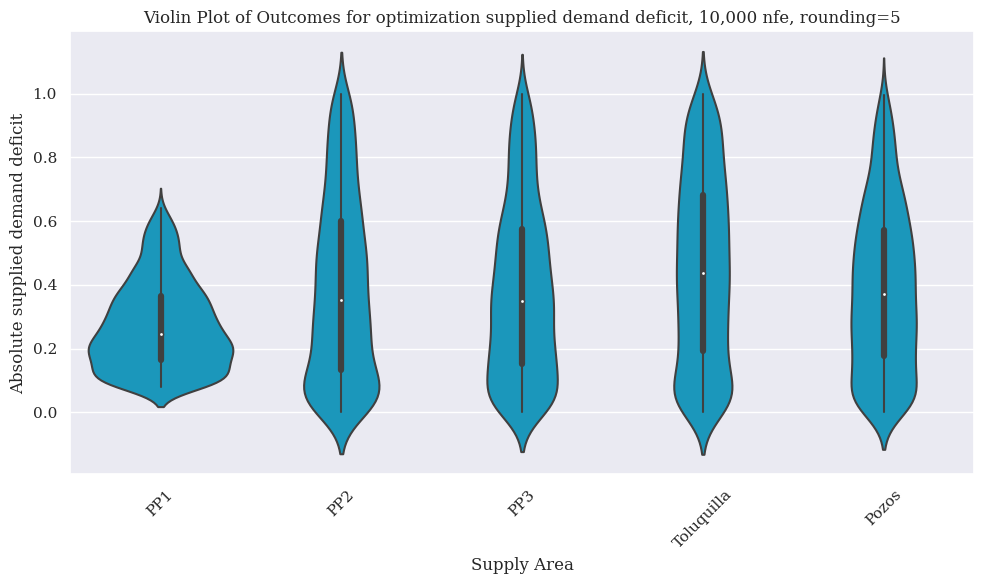

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming 'results' is your dataframe and 'viz_outcomes' is your list of columns
experiment_name = "optimization supplied demand deficit, 10,000 nfe, rounding=5"
viz_outcomes = [f"supplied_demand_deficit_{ZA}" for ZA in ZA_names]
x_axis = "Supply Area"
y_axis = "Absolute supplied demand deficit"

# Set the font to serif
sns.set(font='serif')

# Assuming 'results' is your DataFrame and 'viz_outcomes' is your list of column names
# Assuming 'experiment_name' is a variable containing the experiment name
# Assuming 'ZA_names' is a list containing the names for the x-axis labels
# Assuming 'X_axis' is a variable containing the name for the x-axis
# Assuming 'y_axis' is a variable containing the name for the y-axis

# Create a folder to save the plot if it doesn't exist
folder_path = "experiment_results"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Subset the DataFrame to include only the columns specified in viz_outcomes
viz_data = results[viz_outcomes]

# Melt the DataFrame to long format for plotting
viz_data_melted = viz_data.melt(var_name='Outcome')

# Create the violin plot with customized parameters
plt.figure(figsize=(10, 6))
sns.violinplot(x='Outcome', y='value', data=viz_data_melted, color='#00A6D6', alpha=0.99)
plt.title('Violin Plot of Outcomes for {}'.format(experiment_name))
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.xticks(ticks=range(len(ZA_names)), labels=ZA_names, rotation=45)
plt.tight_layout()

# Save the plot to the experiment_results folder with the given experiment name
file_name = os.path.join(folder_path, experiment_name + '_violin_plot.png')
plt.savefig(file_name)

# Show the plot
plt.show()


In [13]:
policies = results.drop(viz_outcomes, axis =1)


In [14]:
results_df = pd.DataFrame()

from AMG_function import AMG_model_function

for index, row in policies.iterrows():
    # Call the AMG_model function with the values from the current row
    outputs = AMG_model_function(**row.to_dict())  # Pass the row values as keyword arguments
    # Append the outputs as a new row to the results DataFrame
    results_df = results_df.append(outputs, ignore_index=True)

# Display or use the results DataFrame as needed
print(results_df)

      supplied_PP1  supplied_PP2  supplied_PP3  supplied_Toluquilla  \
0         3.153103      0.995783      1.336983             0.920251   
1         3.087911      1.007476      1.432352             0.436593   
2         2.855164      1.025729      1.521428             0.747593   
3         2.855105      1.050625      1.001517             0.673222   
4         3.086578      0.725672      1.441049             0.578104   
...            ...           ...           ...                  ...   
1604      2.976654      0.574240      1.441105             0.593140   
1605      3.186836      0.713969      0.974715             0.992948   
1606      2.411325      1.109487      1.364231             1.058976   
1607      2.722326      1.063672      1.453954             0.881589   
1608      3.331906      0.566156      1.270090             0.729834   

      supplied_Pozos  demand_PP1  demand_PP2  demand_PP3  demand_Toluquilla  \
0           0.771181     2.32436      0.6546     0.76724            

In [15]:
results.to_csv("exp_results/test_opt_drought07.csv")

PermissionError: [Errno 13] Permission denied: 'exp_results/test_opt_drought07.csv'

In [ ]:


deficit_vars = ["deficit_sq_PP1","deficit_sq_PP2","deficit_sq_PP3","deficit_sq_Toluquilla","deficit_sq_Pozos"]
supplied_demand_vars = ["supplied_demand_PP1","supplied_demand_PP2","supplied_demand_PP3","supplied_demand_Toluquilla","supplied_demand_Pozos"]

# Calculate the average of supplied demands per policy
average_demand_per_policy = results[supplied_demand_vars]

# Create a parallel plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
sns.lineplot(data=average_demand_per_policy.T, dashes=False, markers="o", palette="viridis")

# Set plot labels and title
plt.xlabel('Policy')
plt.ylabel('Supplied Demand')
plt.title('Supplied Demands per Policy')

# Show the plot
plt.show()

KeyError: "None of [Index(['supplied_demand_PP1', 'supplied_demand_PP2', 'supplied_demand_PP3',\n       'supplied_demand_Toluquilla', 'supplied_demand_Pozos'],\n      dtype='object')] are in the [columns]"

## 1.2 Formulation 2 with squared deficits outcomes

In [ ]:
from AMG_function import AMG_model

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model)

#define a +- multiplier of 15% for all the uncertainties
lowrange = 0.85
highrange = 1.15

#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

#Specify unceertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]

AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

AMG_model.outcomes = [ScalarOutcome("deficit_sq_PP1", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("deficit_sq_PP2", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("deficit_sq_PP3", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("deficit_sq_Toluquilla", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("deficit_sq_Pozos", kind=ScalarOutcome.MINIMIZE),
                      ScalarOutcome("supplied_demand_PP1", kind=ScalarOutcome.INFO),
                      ScalarOutcome("supplied_demand_PP2", kind=ScalarOutcome.INFO),
                      ScalarOutcome("supplied_demand_PP3", kind=ScalarOutcome.INFO),
                      ScalarOutcome("supplied_demand_Toluquilla", kind=ScalarOutcome.INFO),
                      ScalarOutcome("supplied_demand_Pozos", kind=ScalarOutcome.INFO),
                      ScalarOutcome("min_supplied_demand", kind=ScalarOutcome.INFO)]

#All uncertainties
'''AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),RealParameter('calderon_flow',low_flow,1*high_flow),RealParameter('zapotillo_flow',low_flow,1*high_flow),RealParameter('pozos_flow',low_flow,0.5*high_flow),RealParameter('toluquilla_flow',low_flow,1*high_flow),
                           RealParameter('private_intakes_PP1',445436*lowrange,445436*highrange), RealParameter('private_intakes_PP2',125446*lowrange,125446*highrange), RealParameter('private_intakes_PP3',147032*lowrange,147032*highrange), RealParameter('private_intakes_Toluquilla',128862*lowrange,128862*highrange), RealParameter('private_intakes_Pozos',199613*lowrange,199613*highrange),
                           RealParameter('public_consumption',129*lowrange,129*highrange),
                           RealParameter('crowding_factor',3.55*lowrange,3.55*highrange),
                           RealParameter('node_division',0.35*lowrange,0.35*highrange),
                           RealParameter('loss_grid',0.3*lowrange,0.3*highrange), RealParameter('loss_potabilisation',0.05*lowrange,0.05*highrange),
                           RealParameter('rainfall',0,80*1.5), RealParameter('harvest_coeficient',0.75*lowrange,0.75*highrange), RealParameter('average_household_area',80*lowrange,80*highrange),
                           ]
        '''

In [ ]:
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import ema_logging, Constraint, Scenario

ema_logging.log_to_stderr(ema_logging.INFO)
drougth_multiplier = 0.7
scenario1= Scenario("drought1", chapala_flow = 6.9*drougth_multiplier, calderon_flow = 1*drougth_multiplier, zapotillo_flow = 1*drougth_multiplier, pozos_flow = 2.3*drougth_multiplier, toluquilla_flow = 0.5*drougth_multiplier)

constraints = [Constraint("min_suplied_demand_PP1", outcome_names="supplied_demand_PP1", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_PP2", outcome_names="supplied_demand_PP2", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_PP3", outcome_names="supplied_demand_PP3", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_Toluquilla", outcome_names="supplied_demand_Toluquilla", function=lambda x: max(0, -x)),
               Constraint("min_suplied_demand_Pozos", outcome_names="supplied_demand_Pozos", function=lambda x: max(0, -x))]

with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=250, searchover="levers", epsilons=[0.001] * 5, reference=scenario1
    )

results.head(40)

In [ ]:
df = results[deficit_vars]
df["average_deficit_sq"] = round(df.mean(axis=1),2)

#Filter the policies to the top n with lowest average deficit sq
n=5
df = df.nsmallest(n,["average_deficit_sq"])


df.head()

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

deficit_vars = ["deficit_sq_PP1","deficit_sq_PP2","deficit_sq_PP3","deficit_sq_Toluquilla","deficit_sq_Pozos"]

# Calculate the average of supplied demands per policy
df = results[deficit_vars]
df["average_deficit_sq"] = df.mean(axis=1)

#Filter the policies to the top n with lowest average deficit sq
n=5
df = df.nsmallest(n,["average_deficit_sq"])

#reconvert to fix units
df = round(df**0.5,4)


# Plot parallel coordinates
plt.figure(figsize=(10, 6))
pd.plotting.parallel_coordinates(df, 'average_deficit_sq', colormap='viridis')

# Create and set the legend title
plt.legend(title='Average Deficit m3/s')

# Set plot labels and title
plt.xlabel('Supply Areas')
plt.ylabel('Deficit m3/s')
plt.title('Parallel Coordinates Plot')

# Show the plot
plt.show()

## 2. Single scenario with uncertainty (not implemented)


In [ ]:
from AMG_function import AMG_model

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model)


AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

AMG_model.outcomes = [ScalarOutcome("supplied_demand_PP1", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP2", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP3", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Toluquilla", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Pozos", kind=ScalarOutcome.MAXIMIZE)]



#All uncertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),RealParameter('calderon_flow',low_flow,1*high_flow),RealParameter('zapotillo_flow',low_flow,1*high_flow),RealParameter('pozos_flow',low_flow,0.5*high_flow),RealParameter('toluquilla_flow',low_flow,1*high_flow),
                           RealParameter('private_intakes_PP1',445436*lowrange,445436*highrange), RealParameter('private_intakes_PP2',125446*lowrange,125446*highrange), RealParameter('private_intakes_PP3',147032*lowrange,147032*highrange), RealParameter('private_intakes_Toluquilla',128862*lowrange,128862*highrange), RealParameter('private_intakes_Pozos',199613*lowrange,199613*highrange),
                           RealParameter('public_consumption',129*lowrange,129*highrange),
                           RealParameter('crowding_factor',3.55*lowrange,3.55*highrange),
                           RealParameter('node_division',0.35*lowrange,0.35*highrange),
                           RealParameter('loss_grid',0.3*lowrange,0.3*highrange), RealParameter('loss_potabilisation',0.05*lowrange,0.05*highrange),
                           RealParameter('rainfall',0,80*1.5), RealParameter('harvest_coeficient',0.75*lowrange,0.75*highrange), RealParameter('average_household_area',80*lowrange,80*highrange),
                           ]


#define a +- multiplier of 15% for all the uncertainties
lowrange = 0.85
highrange = 1.15

#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

#Specify unceertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]
        

# 3. Multiple drought scenarios, no uncerainty (not implemented)


In [ ]:
from AMG_function import AMG_model_function

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model)


AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,1),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

AMG_model.outcomes = [ScalarOutcome("supplied_demand_PP1", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP2", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_PP3", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Toluquilla", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_Pozos", kind=ScalarOutcome.MAXIMIZE)]

#define a +- multiplier of 15% for all the uncertainties
lowrange = 0.85
highrange = 1.15

#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

#Specify unceertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]

# Robust optimization


In [ ]:
'''#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]'''